# Lab 5 - Multivariate Regression, Non-Parametric Models and Cross-Validation

**Name: Chen, Kun**

**ID: 8977010**

In [142]:
import lux
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn import datasets
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.datasets import load_diabetes

### 1. Load Dataset

In [143]:
data, target = datasets.load_diabetes(return_X_y=True, as_frame=True, scaled=True)

temp = datasets.load_diabetes(scaled=False)
diabetes= pd.DataFrame(data=np.c_[temp['data'], temp['target']],
                     columns=temp['feature_names'] + ['target'])
diabetes.describe()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

### 2. EDA

In [144]:
diabetes.info()
print(diabetes.isnull().to_numpy().all())
diabetes = diabetes.dropna()
diabetes = diabetes.drop_duplicates()
diabetes.describe()

<class 'lux.core.frame.LuxDataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     442 non-null    float64
 3   bp      442 non-null    float64
 4   s1      442 non-null    float64
 5   s2      442 non-null    float64
 6   s3      442 non-null    float64
 7   s4      442 non-null    float64
 8   s5      442 non-null    float64
 9   s6      442 non-null    float64
 10  target  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB
False


Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [145]:
diabetes

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

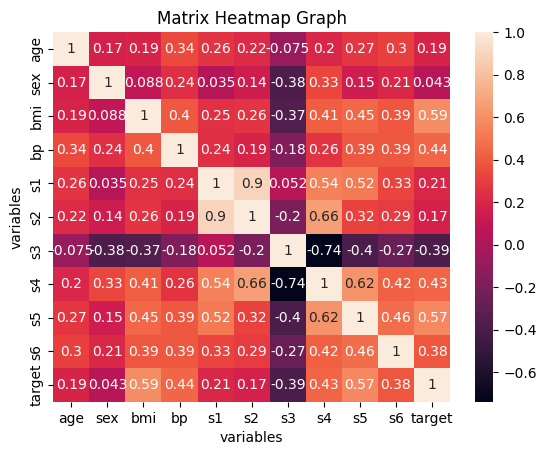

In [146]:

sn.heatmap(diabetes.corr(), annot=True)
plt.title('Matrix Heatmap Graph')
plt.xlabel('variables') 
plt.ylabel('variables')
plt.show()

You can see that the gender data has a weak correlation with target (0.043) and it can be deleted

In [147]:
x = np.array(data)
y = np.array(target)

train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1 - train_ratio)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

In [174]:
poly_models = {}
for degree in [3, 4]:
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(x_train)
    poly_models[f'Polynomial {degree}'] = LinearRegression()

decision_tree_models = {}
for max_depth in [3, 4]:
    decision_tree_models[f'Decision Tree {max_depth}'] = DecisionTreeRegressor(max_depth=max_depth)

knn_models = {}
for n_neighbors in [3, 5]:
    knn_models[f'kNN {n_neighbors}'] = KNeighborsRegressor(n_neighbors=n_neighbors)

models = {**poly_models, **decision_tree_models, **knn_models}

scoring = {'r2': make_scorer(r2_score),
           'mae': make_scorer(mean_absolute_error),
           'mape': make_scorer(mean_absolute_percentage_error)}

results = []
cv = KFold(n_splits=5, shuffle=True, random_state=1)
for name, model in models.items():
    cv_results = cross_validate(model, x_train, y_train, scoring=scoring, cv=cv)
    r2_mean = cv_results['test_r2'].mean()
    r2_std = cv_results['test_r2'].std()
    mae_mean = cv_results['test_mae'].mean()
    mae_std = cv_results['test_mae'].std()
    mape_mean = cv_results['test_mape'].mean()
    mape_std = cv_results['test_mape'].std()
    results.append([name, r2_mean, r2_std, mae_mean, mae_std, mape_mean, mape_std])

columns = ['Model', 'R-Squared Mean', 'R-Squared Std', 'MAE Mean', 'MAE Std', 'MAPE Mean', 'MAPE Std']
results_df = pd.DataFrame(results, columns=columns)

print(results_df)

             Model  R-Squared Mean  R-Squared Std   MAE Mean   MAE Std  \
0     Polynomial 3        0.473657       0.097020  43.293320  1.196790   
1     Polynomial 4        0.473657       0.097020  43.293320  1.196790   
2  Decision Tree 3        0.326672       0.118197  48.765266  3.532689   
3  Decision Tree 4        0.293291       0.147919  49.314410  4.330642   
4            kNN 3        0.307480       0.082549  48.774828  2.861713   
5            kNN 5        0.350384       0.054182  47.559112  2.834544   

   MAPE Mean  MAPE Std  
0   0.383909  0.048525  
1   0.383909  0.048525  
2   0.420709  0.022040  
3   0.432042  0.029499  
4   0.417687  0.050789  
5   0.409906  0.047942  


Base on above result, KNN 5 is the best Model

In [175]:
knn_model = models['kNN 5']
knn_model.fit(x_test, y_test)
y_pred_test = knn_model.predict(x_test)

r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print('Test Set Performance for kNN 5:')
print('R-Squared: %.3f' % r2_test)
print('MAE: %.3f' % mae_test)
print('MAPE: %.3f' % mape_test)

Test Set Performance for kNN 5:
R-Squared: 0.651
MAE: 38.340
MAPE: 33.483


(309, 10) (309,)


ValueError: x and y must be the same size

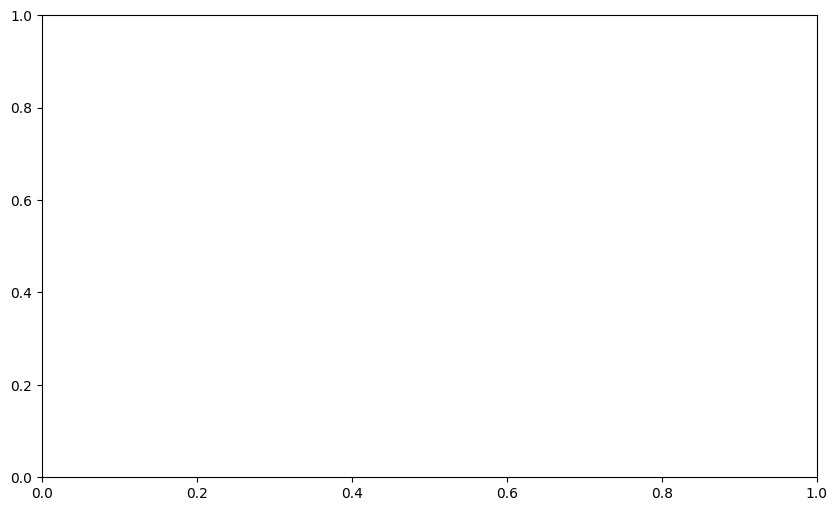

In [176]:
y_pred = knn_model.predict(x) 
plt.figure(figsize=(10, 6))

print(x_train.shape, y_train.shape)
#plt.scatter(x_train.reshape(-1), y_train, color='blue', label='Train Data')
plt.scatter(x_test, y_test, color='red', label='Test Data')
plt.scatter(x_test, y_test, color='green', label='Validation Data')

plt.plot(x, y_pred, color='block', label='KNN 5 Model')

plt.xlabel('X')
plt.ylabel('y')
plt.title('KNN 5 Model for Diabetes')
plt.legend()
plt.show()